In [152]:
import numpy as np
import pandas as pd
import glob
import copy

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBRegressor
from xgboost import XGBClassifier

import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd


In [153]:
np.random.seed(4)

In [154]:
# test_df.csv == not_loop_10000_result
target_df = pd.read_csv("data/test/test_df.csv")
target_df

,date,transaction_count,transaction_amount,transaction_flag,returns,close,abs_returns,volume,open,high,low,high_low,daily_avg_trades,daily_sum_trades,daily_sum_taker_buy_base_asset_volume,daily_sum_taker_buy_quote_asset_volume,daily_avg_spread,daily_quote_asset_volume,daily_avg_quote_asset_volume,daily_low,daily_high,daily_avg_price,daily_vwap,daily_avg_volume,daily_morning_returns,daily_afternoon_returns,daily_night_returns,daily_dawn_returns,daily_avg_morning_returns,daily_avg_afternoon_returns,daily_avg_night_returns,daily_avg_dawn_returns,daily_avg_morning_volume,daily_avg_afternoon_volume,daily_avg_night_volume,daily_avg_dawn_volume,daily_morning_volatility,daily_afternoon_volatility,daily_night_volatility,daily_dawn_volatility,daily_volatility,avg-block-size,blocks-size,cost-per-transaction-percent,cost-per-transaction,difficulty,estimated-transaction-volume-usd,estimated-transaction-volume,fees-usd-per-transaction,hash-rate,market-price,median-confirmation-time,miners-revenue,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-transactions,n-unique-addresses,output-volume,trade-volume,transaction-fees-usd,transaction-fees,n-payments-per-block,n-payments,avg-confirmation-time
0,2017-01-01,0,0.000000e+00,0,NaN,4285.08,NaN,795.150377,4261.48,4485.39,4200.74,284.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,0,0.000000e+00,0,-0.041238,4108.37,0.041238,1199.888264,4285.08,4371.52,3938.77,432.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.944878,97293.875547,0.763861,7.350606,3.176884e+11,2.799811e+08,275190.258573,0.394819,2.526780e+06,997.36,9.816667,2.138666e+06,287576.0,1829.880503,1.839618e+08,290951.0,529709.0,1.573982e+06,6.822471e+06,114872.988609,112.884147,NaN,NaN,NaN
2,2017-01-03,0,0.000000e+00,0,0.007694,4139.98,0.007694,381.309763,4108.37,4184.69,3850.00,334.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.906574,97444.110856,0.656971,7.415466,3.176884e+11,3.417543e+08,333533.011560,0.398843,2.589950e+06,1013.42,12.350000,2.245225e+06,297536.0,1839.414634,1.842534e+08,301664.0,515024.0,1.950525e+06,8.324526e+06,120759.971352,117.508697,NaN,NaN,NaN
3,2017-01-04,0,0.000000e+00,0,-0.012969,4086.29,0.012969,467.083022,4139.98,4211.08,4032.62,178.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.986063,97592.788943,0.537835,7.000531,3.176884e+11,4.336781e+08,396990.165288,0.644994,2.432026e+06,1037.83,10.700000,2.332472e+06,325192.0,2147.986928,1.845561e+08,328642.0,545609.0,2.482038e+06,9.340584e+06,214902.266038,193.337436,NaN,NaN,NaN
4,2017-01-05,1,3.936639e+13,1,-0.017201,4016.00,0.017201,691.743060,4086.29,4119.62,3911.79,207.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.984197,97743.656720,0.355227,6.913398,3.176884e+11,5.657800e+08,528064.193962,0.419516,2.210933e+06,1109.16,10.916667,2.009801e+06,283920.0,2060.721429,1.848845e+08,288501.0,495910.0,2.998215e+06,2.387011e+07,121958.044759,114.991943,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2825,2024-09-26,0,0.000000e+00,0,0.032018,65173.99,0.032018,28373.305930,63152.01,65839.00,62670.00,3169.00,50.478391,4361333.0,15041.98860,9.711762e+08,0.000005,1.831205e+09,21194.497638,62670.00,65839.00,64278.054721,64540.884675,0.328395,0.012580,0.011469,0.000636,0.006999,5.796342e-07,5.319940e-07,3.103639e-08,3.237245e-07,0.251817,0.666416,0.210727,

In [155]:
# # 기간 조정
# target_df = target_df[target_df['date']>='2018-01-01']
target_df = target_df[(target_df['date']>='2018-01-01')&(target_df['date']<='2024-09-30')]

C:\Users\slaye\AppData\Local\Temp\ipykernel_23968\3267513000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['date'] = pd.to_datetime(target_df['date'])


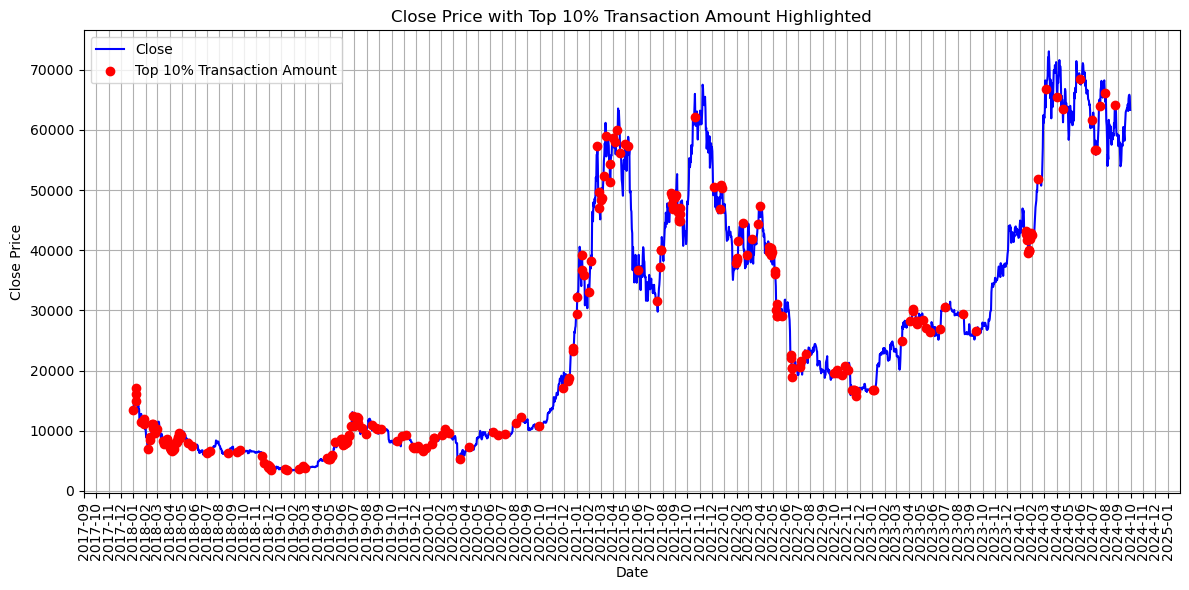

In [156]:

# 'date' 열을 datetime 형식으로 변환
target_df['date'] = pd.to_datetime(target_df['date'])

# transaction_amount의 상위 10% 기준 계산
threshold = target_df['transaction_amount'].quantile(0.90)

# 상위 10% 조건에 맞는 인덱스 필터링
high_transaction_days = target_df[target_df['transaction_amount'] > threshold]

# 전체 close 데이터 그래프
plt.figure(figsize=(12, 6))
plt.plot(target_df['date'], target_df['close'], label='Close', color='blue')  # X축: 'date', Y축: 'close'

# 상위 10% transaction_amount가 발생한 날의 close 값에 점 찍기
plt.scatter(high_transaction_days['date'], high_transaction_days['close'], color='red', label='Top 10% Transaction Amount', zorder=5)  # X축: 'date', Y축: 'close'

# 날짜 축 포맷 설정 (1달 간격)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # 1달 간격으로 표시
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 연-월 형식으로 표시

# 그래프 꾸미기
plt.title('Close Price with Top 10% Transaction Amount Highlighted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=90)  # X축 라벨 회전
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [157]:
target_df['target'] = target_df['transaction_amount']

test_target_df_1 = copy.deepcopy(target_df[['date', 'transaction_amount']])
test_target_df_2 = copy.deepcopy(target_df[['date', 'transaction_count']])
test_target_df_3 = copy.deepcopy(target_df[['date', 'transaction_flag']])

test_target_df_1 = test_target_df_1.set_index('date')
test_target_df_2 = test_target_df_2.set_index('date')
test_target_df_3 = test_target_df_3.set_index('date')

target_df = target_df.drop(['transaction_count', 'transaction_amount', 'transaction_flag'], axis=1)

C:\Users\slaye\AppData\Local\Temp\ipykernel_23968\1547922168.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['target'] = target_df['transaction_amount']


In [158]:
target_df.set_index('date', inplace=True)
target_df

,returns,close,abs_returns,volume,open,high,low,high_low,daily_avg_trades,daily_sum_trades,daily_sum_taker_buy_base_asset_volume,daily_sum_taker_buy_quote_asset_volume,daily_avg_spread,daily_quote_asset_volume,daily_avg_quote_asset_volume,daily_low,daily_high,daily_avg_price,daily_vwap,daily_avg_volume,daily_morning_returns,daily_afternoon_returns,daily_night_returns,daily_dawn_returns,daily_avg_morning_returns,daily_avg_afternoon_returns,daily_avg_night_returns,daily_avg_dawn_returns,daily_avg_morning_volume,daily_avg_afternoon_volume,daily_avg_night_volume,daily_avg_dawn_volume,daily_morning_volatility,daily_afternoon_volatility,daily_night_volatility,daily_dawn_volatility,daily_volatility,avg-block-size,blocks-size,cost-per-transaction-percent,cost-per-transaction,difficulty,estimated-transaction-volume-usd,estimated-transaction-volume,fees-usd-per-transaction,hash-rate,market-price,median-confirmation-time,miners-revenue,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-transactions,n-unique-addresses,output-volume,trade-volume,transaction-fees-usd,transaction-fees,n-payments-per-block,n-payments,avg-confirmation-time,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-0.024523,13380.00,0.024523,8609.915844,13716.36,13818.55,12750.00,1068.55,1.271124,98821.0,3699.634259,4.931474e+07,0.000948,1.077702e+08,1386.237160,12750.00,13818.55,13364.212983,13332.010686,0.103979,-0.010975,0.012634,0.017765,-0.014662,-3.393855e-07,9.075408e-07,1.101233e-06,-4.732937e-07,0.091872,0.116106,0.091282,0.115332,0.000684,0.000740,0.000551,0.000721,0.000680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.362702e+14
2018-01-02,0.096794,14675.11,0.096794,20078.092111,13382.16,15473.49,12890.02,2583.47,2.060408,176954.0,11289.353955,1.573041e+08,0.000935,2.783978e+08,3241.594264,12890.02,15473.49,13811.039480,13933.086632,0.232657,0.032595,0.021497,0.062829,-0.029981,1.669951e-06,1.197538e-06,3.238834e-06,-1.129231e-06,0.184262,0.241013,0.320807,0.183597,0.000582,0.000652,0.000910,0.000770,0.000739,1.041368,150273.540487,1.196300,113.842161,1.931136e+12,3.339191e+09,240354.960602,26.475555,1.641554e+07,13374.98,7.983333,3.994676e+07,324425.0,1994.035088,2.880879e+08,340980.0,850802.0,2.536939e+06,6.606965e+08,9.290166e+06,649.164976,4026.590643,688547.0,NaN,0.000000e+00
2018-01-03,0.016654,14919.51,0.016654,15905.667639,14675.11,15307.56,14150.00,1157.56,1.908600,160916.0,8898.982058,1.321625e+08,0.000892,2.340518e+08,2776.052453,14150.00,15307.56,14854.690656,14845.989226,0.187004,-0.017210,0.006740,0.019180,0.021882,-4.704536e-07,5.198397e-07,1.137113e-06,1.202226e-06,0.267372,0.136874,0.107814,0.228883,0.000818,0.000639,0.000601,0.000632,0.000679,1.065513,150451.629839,1.421423,102.462144,1.931136e+12,2.887038e+09,192904.469212,28.276123,1.507158e+07,14793.46,9.550000,4.103701e+07,376433.0,2522.057325,2.884291e+08,395963.0,937531.0,2.816885e+06,1.365239e+09,1.132484e+07,749.685473,4718.490446,740803.0,NaN,0.000000e+00
2018-01-04,0.009386,15059.54,0.009386,21329.649574,14919.51,15280.00,13918.04,1361.96,2.166096,170110.0,12653.920866,1.857209e+08,0.001049,3.121460e+08,3974.711105,13918.04,15280.00,14682.204273,14664.329027,0.271050,-0.020753,0.006550,0.025190,-0.003442,-6.401308e-07,6.505802e-07,1.489424e-06,-3.997053e-08,0.291351,0.276316,0.237750,0.282984,0.000814,0.000833,0.000818,0.000645,0.000793,1.065833,150618.904617,1.078912,100.526983,1.931136e+12,3.959988e+09,266691.835512,27.181791,1.612755e+07,15039.24,13.950000,4.272477e+07,402643.0,2529.809524,2.888257e+08,425008.0,1054712.0,2.737825e+06,1.059923e+09,1.155248e+07,778.261095,5122.785714,860628.0,NaN,1.030237e+13
2018-01-05,0.126222,16960.39,0.126222,23251.491125,15059.54,17176.24,14600.00,2576.24,2.234184,192857.0,13342.521874,2.117683e+08,0.001027,3.691787e+08,4276.811845,14600.00,17176.24,15845.913763,15883.307167,0.269251,0.073369,0.034760,0.018638,-0.001319,3.6013

In [159]:
# 결측치 처리
target_df = target_df.fillna(target_df.mean())

In [160]:
# 독립변수를 하루씩 밀어서 과거 데이터를 통해 다음날 target 값 예측 Task
shifted_columns = target_df.columns.difference(['n-unique-addresses', 'target'])
shifted_df = target_df[shifted_columns].shift(1)

shifted_columns = shifted_df.columns + '_shifted'
shifted_df.columns = shifted_columns

combined_df = pd.concat([shifted_df], axis=1)
combined_df

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,close_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,daily_avg_afternoon_volume_shifted,daily_avg_dawn_returns_shifted,daily_avg_dawn_volume_shifted,daily_avg_morning_returns_shifted,daily_avg_morning_volume_shifted,daily_avg_night_returns_shifted,daily_avg_night_volume_shifted,daily_avg_price_shifted,daily_avg_quote_asset_volume_shifted,daily_avg_spread_shifted,daily_avg_trades_shifted,daily_avg_volume_shifted,daily_dawn_returns_shifted,daily_dawn_volatility_shifted,daily_high_shifted,daily_low_shifted,daily_morning_returns_shifted,daily_morning_volatility_shifted,daily_night_returns_shifted,daily_night_volatility_shifted,daily_quote_asset_volume_shifted,daily_sum_taker_buy_base_asset_volume_shifted,daily_sum_taker_buy_quote_asset_volume_shifted,daily_sum_trades_shifted,daily_volatility_shifted,daily_vwap_shifted,difficulty_shifted,estimated-transaction-volume_shifted,estimated-transaction-volume-usd_shifted,fees-usd-per-transaction_shifted,hash-rate_shifted,high_shifted,high_low_shifted,low_shifted,market-price_shifted,median-confirmation-time_shifted,miners-revenue_shifted,n-payments_shifted,n-payments-per-block_shifted,n-transactions_shifted,n-transactions-excluding-popular_shifted,n-transactions-per-block_shifted,n-transactions-total_shifted,open_shifted,output-volume_shifted,returns_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,0.024523,1.263132,212.466831,352000.393335,13380.00,84.346074,1.377038,0.012634,0.000740,9.075408e-07,0.116106,-4.732937e-07,0.115332,-3.393855e-07,0.091872,1.101233e-06,0.091282,13364.212983,1386.237160,0.000948,1.271124,0.103979,-0.014662,0.000721,13818.55,12750.00,-0.010975,0.000684,0.017765,0.000551,1.077702e+08,3699.634259,4.931474e+07,98821.0,0.000680,13332.010686,2.897504e+13,137642.922705,1.779227e+09,4.033708,2.100334e+08,13818.55,1068.55,12750.00,21735.929071,9.132760,2.594920e+07,6.700324e+05,4607.731346,325008.502646,320012.586488,2230.526390,6.399782e+08,13716.36,1.728889e+06,-0.024523,3.251735e+08,54.871887,1.432854e+06,8609.915844
2018-01-03,0.096794,1.041368,212.466831,150273.540487,14675.11,113.842161,1.196300,0.021497,0.000652,1.197538e-06,0.241013,-1.129231e-06,0.183597,1.669951e-06,0.184262,3.238834e-06,0.320807,13811.039480,3241.594264,0.000935,2.060408,0.232657,-0.029981,0.000770,15473.49,12890.02,0.032595,0.000582,0.062829,0.000910,2.783978e+08,11289.353955,1.573041e+08,176954.0,0.000739,13933.086632,1.931136e+12,240354.960602,3.339191e+09,26.475555,1.641554e+07,15473.49,2583.47,12890.02,13374.980000,7.983333,3.994676e+07,6.885470e+05,4026.590643,340980.000000,324425.000000,1994.035088,2.880879e+08,13382.16,2.536939e+06,0.096794,6.606965e+08,649.164976,9.290166e+06,20078.092111
2018-01-04,0.016654,1.065513,212.466831,150451.629839,14919.51,102.462144,1.421423,0.006740,0.000639,5.198397e-07,0.136874,1.202226e-06,0.228883,-4.704536e-07,0.267372,1.137113e-06,0.107814,14854.690656,2776.052453,0.000892,1.908600,0.187004,0.021882,0.000632,15307.56,14150.00,-0.017210,0.000818,0.019180,0.000601,2.340518e+08,8898.982058,1.321625e+08,160916.0,0.000679,14845.989226,1.931136e+12,192904.469212,2.887038e+09,28.276123,1.507158e+07,15307.56,1157.56,14150.00,14793.460000,9.550000,4.103701e+07,7.408030e+05,4718.490446,395963.000000,376433.000000,2522.057325,2.884291e+08,14675.11,2.816885e+06,0.016654,1.365239e+09,749.685473,1.132484e+07,15905.667639
2018-01-05,0.009386,1.065833,212.466831,150618.90461

In [161]:
combined_df = combined_df.dropna()
combined_df['target'] = target_df['target']

C:\Users\slaye\AppData\Local\Temp\ipykernel_23968\654935881.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['target'] = target_df['target']


In [162]:
# 스케일링
scaler = MinMaxScaler()

scaled_df = pd.DataFrame(scaler.fit_transform(combined_df), columns=combined_df.columns)
scaled_df

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,close_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,daily_avg_afternoon_volume_shifted,daily_avg_dawn_returns_shifted,daily_avg_dawn_volume_shifted,daily_avg_morning_returns_shifted,daily_avg_morning_volume_shifted,daily_avg_night_returns_shifted,daily_avg_night_volume_shifted,daily_avg_price_shifted,daily_avg_quote_asset_volume_shifted,daily_avg_spread_shifted,daily_avg_trades_shifted,daily_avg_volume_shifted,daily_dawn_returns_shifted,daily_dawn_volatility_shifted,daily_high_shifted,daily_low_shifted,daily_morning_returns_shifted,daily_morning_volatility_shifted,daily_night_returns_shifted,daily_night_volatility_shifted,daily_quote_asset_volume_shifted,daily_sum_taker_buy_base_asset_volume_shifted,daily_sum_taker_buy_quote_asset_volume_shifted,daily_sum_trades_shifted,daily_volatility_shifted,daily_vwap_shifted,difficulty_shifted,estimated-transaction-volume_shifted,estimated-transaction-volume-usd_shifted,fees-usd-per-transaction_shifted,hash-rate_shifted,high_shifted,high_low_shifted,low_shifted,market-price_shifted,median-confirmation-time_shifted,miners-revenue_shifted,n-payments_shifted,n-payments-per-block_shifted,n-transactions_shifted,n-transactions-excluding-popular_shifted,n-transactions-per-block_shifted,n-transactions-total_shifted,open_shifted,output-volume_shifted,returns_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted,target
0,0.062062,0.397299,0.008012,0.444484,0.145551,0.235012,0.225061,0.504394,0.422148,0.554609,0.004060,0.246000,0.008278,0.497545,0.004308,0.666715,0.004218,0.146114,0.004644,0.434526,0.002384,0.003975,0.461429,0.355569,0.149532,0.140718,0.594168,0.385130,0.704034,0.250900,0.005505,0.007641,0.004878,0.005685,0.389488,0.145630,0.298036,0.181199,0.105766,0.030535,0.269269,0.149532,0.076581,0.140718,0.287641,0.279095,0.206448,0.299529,0.344747,0.249721,0.245087,0.298134,0.440201,0.150366,0.056882,0.627574,0.090818,0.039587,0.017100,0.009343,0.000000
1,0.245009,0.291361,0.008012,0.000000,0.164089,0.339492,0.191385,0.544508,0.371442,0.583314,0.013022,0.213042,0.016486,0.605440,0.015135,0.788558,0.023524,0.152545,0.013843,0.428481,0.006886,0.018705,0.398256,0.380053,0.173006,0.142772,0.726496,0.327592,0.840339,0.416022,0.015289,0.027952,0.017189,0.010826,0.423936,0.154276,0.000000,0.351093,0.211820,0.207418,0.003687,0.173006,0.188348,0.142772,0.157672,0.230114,0.342229,0.313033,0.279861,0.269626,0.250577,0.247643,0.000000,0.145582,0.090307,0.833053,0.189768,0.514102,0.114100,0.024459,0.000000
2,0.042144,0.302896,0.008012,0.000392,0.167588,0.299182,0.233331,0.477716,0.364024,0.516232,0.005550,0.330190,0.021932,0.490508,0.024874,0.668761,0.005609,0.167568,0.011535,0.408822,0.006020,0.013479,0.612130,0.311024,0.170652,0.161253,0.575232,0.461511,0.708314,0.273813,0.012746,0.021555,0.014323,0.009770,0.389206,0.167408,0.000000,0.272606,0.181080,0.221609,0.001843,0.170652,0.083148,0.161253,0.179722,0.296875,0.352805,0.351145,0.357114,0.338152,0.315280,0.360377,0.000427,0.164089,0.101887,0.697316,0.397545,0.594363,0.139219,0.018959,0.001762
3,0.023745,0.303048,0.008012,0.000761,0.169592,0.292328,0.169512,0.476855,0.475962,0.529174,0.015555,0.267773,0.028438,0.481396,0.027684,0.688842,0.016538,0.165085,0.017478,0.480523,0.007488,0.023099,0.507698,0.317527,0.170261,0.157850,0.564472,0.459206,0.726492,0.373742,0.017224,0.031604,0.020429,0.010375,0.455150,0.164795,0.000000,0.394656,0.254025,0.212984,0.003292,0.170261,0.098228,0.157850,0.183542,0.484375,0.369177,0.438538,0.402255,0.374351,0.347888,0.362032,0.000923,0.167588,0.098617,0.685006,0.307504,0.617179,0.142029,0.026108,0.006284
4,0.319502,0.303910,0.008012,0.001155,0.196801,0.341465,0.122712,0.604542,0.445200,0.651504,0.014752,0.285796,0.024686,0.709149,0.025368,0.673799,0.020806,0.

In [163]:
y = scaled_df['target'].values
X = scaled_df.drop('target', axis=1)

In [164]:
## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [165]:
# shift 1, Linear Regression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
print('훈련 세트 R2 :', lr.score(X_train, y_train))

# 테스트 셋 예측
lr_y_pred = lr.predict(X_test)

# 정확도
predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': lr_y_pred})
predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
predict_df['diff_abs'] = predict_df['diff'].abs()
predict_df['diff_squared'] = predict_df['diff']**2
print("MAE:", predict_df['diff_abs'].mean())
print("MSE:", predict_df['diff_squared'].mean())
print("R2:", lr.score(X_test, y_test))

훈련 세트 R2 : 0.04657599986675354
MAE: 0.015458323270577654
MSE: 0.000519418429540063
R2: -3.918388389748186


In [166]:
# XGBR = XGBRegressor(n_estimators=10000, gamma=4.376, subsample=0.70, learning_rate=0.08, max_depth=6, objective='reg:squarederror')
# XGBR.fit(X_train, y_train)

# predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
# predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
# predict_df['diff_abs'] = predict_df['diff'].abs()
# predict_df['diff_squared'] = predict_df['diff']**2
# print("MAE:", predict_df['diff_abs'].mean())
# print("MSE:", predict_df['diff_squared'].mean())
# print("R2:", XGBR.score(X_test, y_test))

In [167]:
# # 현재 모델
# XGBR = XGBRegressor(n_estimators=100000, gamma=0.006, subsample=0.70, learning_rate=0.08, max_depth=3, objective='reg:squarederror')
# XGBR.fit(X_train, y_train)

# predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
# predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
# predict_df['diff_abs'] = predict_df['diff'].abs()
# predict_df['diff_squared'] = predict_df['diff']**2
# print("MAE:", predict_df['diff_abs'].mean())
# print("MSE:", predict_df['diff_squared'].mean())
# print("R2:", XGBR.score(X_test, y_test))

In [168]:
# 현재 모델
XGBR = XGBRegressor(n_estimators=100000, gamma=0.002, subsample=0.90, learning_rate=0.08, max_depth=3, objective='reg:squarederror')
XGBR.fit(X_train, y_train)

predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
predict_df['diff_abs'] = predict_df['diff'].abs()
predict_df['diff_squared'] = predict_df['diff']**2
print("MAE:", predict_df['diff_abs'].mean())
print("MSE:", predict_df['diff_squared'].mean())
print("R2:", XGBR.score(X_test, y_test))

MAE: 0.015081897127733055
MSE: 0.0004736786309860497
R2: -3.485276891650816


In [169]:
XGBR.save_model('models/xgb_model_amount_250203.json')

In [170]:
# 모델 불러오기
XGBR = XGBRegressor()
XGBR.load_model('models/xgb_model_amount_250203.json')

# Error, R2 평가
predict_df = pd.DataFrame({'y_test': y_test, 'y_pred': XGBR.predict(X_test)})
predict_df['diff'] = predict_df['y_test'] - predict_df['y_pred']
predict_df['diff_abs'] = predict_df['diff'].abs()
predict_df['diff_squared'] = predict_df['diff']**2
print("MAE:", predict_df['diff_abs'].mean())
print("MSE:", predict_df['diff_squared'].mean())
print("R2:", XGBR.score(X_test, y_test))

MAE: 0.015081897127733055
MSE: 0.0004736786309860497
R2: -3.485276891650816


In [171]:
xxx_amount = XGBR.predict(X)
test_X = copy.deepcopy(X)
test_X['ITI_amount'] = xxx_amount
test_X.index = combined_df.index
test_X

,abs_returns_shifted,avg-block-size_shifted,avg-confirmation-time_shifted,blocks-size_shifted,close_shifted,cost-per-transaction_shifted,cost-per-transaction-percent_shifted,daily_afternoon_returns_shifted,daily_afternoon_volatility_shifted,daily_avg_afternoon_returns_shifted,daily_avg_afternoon_volume_shifted,daily_avg_dawn_returns_shifted,daily_avg_dawn_volume_shifted,daily_avg_morning_returns_shifted,daily_avg_morning_volume_shifted,daily_avg_night_returns_shifted,daily_avg_night_volume_shifted,daily_avg_price_shifted,daily_avg_quote_asset_volume_shifted,daily_avg_spread_shifted,daily_avg_trades_shifted,daily_avg_volume_shifted,daily_dawn_returns_shifted,daily_dawn_volatility_shifted,daily_high_shifted,daily_low_shifted,daily_morning_returns_shifted,daily_morning_volatility_shifted,daily_night_returns_shifted,daily_night_volatility_shifted,daily_quote_asset_volume_shifted,daily_sum_taker_buy_base_asset_volume_shifted,daily_sum_taker_buy_quote_asset_volume_shifted,daily_sum_trades_shifted,daily_volatility_shifted,daily_vwap_shifted,difficulty_shifted,estimated-transaction-volume_shifted,estimated-transaction-volume-usd_shifted,fees-usd-per-transaction_shifted,hash-rate_shifted,high_shifted,high_low_shifted,low_shifted,market-price_shifted,median-confirmation-time_shifted,miners-revenue_shifted,n-payments_shifted,n-payments-per-block_shifted,n-transactions_shifted,n-transactions-excluding-popular_shifted,n-transactions-per-block_shifted,n-transactions-total_shifted,open_shifted,output-volume_shifted,returns_shifted,trade-volume_shifted,transaction-fees_shifted,transaction-fees-usd_shifted,volume_shifted,ITI_amount
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.062062,0.397299,0.008012,0.444484,0.145551,0.235012,0.225061,0.504394,0.422148,0.554609,0.004060,0.246000,0.008278,0.497545,0.004308,0.666715,0.004218,0.146114,0.004644,0.434526,0.002384,0.003975,0.461429,0.355569,0.149532,0.140718,0.594168,0.385130,0.704034,0.250900,0.005505,0.007641,0.004878,0.005685,0.389488,0.145630,0.298036,0.181199,0.105766,0.030535,0.269269,0.149532,0.076581,0.140718,0.287641,0.279095,0.206448,0.299529,0.344747,0.249721,0.245087,0.298134,0.440201,0.150366,0.056882,0.627574,0.090818,0.039587,0.017100,0.009343,0.005130
2018-01-03,0.245009,0.291361,0.008012,0.000000,0.164089,0.339492,0.191385,0.544508,0.371442,0.583314,0.013022,0.213042,0.016486,0.605440,0.015135,0.788558,0.023524,0.152545,0.013843,0.428481,0.006886,0.018705,0.398256,0.380053,0.173006,0.142772,0.726496,0.327592,0.840339,0.416022,0.015289,0.027952,0.017189,0.010826,0.423936,0.154276,0.000000,0.351093,0.211820,0.207418,0.003687,0.173006,0.188348,0.142772,0.157672,0.230114,0.342229,0.313033,0.279861,0.269626,0.250577,0.247643,0.000000,0.145582,0.090307,0.833053,0.189768,0.514102,0.114100,0.024459,0.006214
2018-01-04,0.042144,0.302896,0.008012,0.000392,0.167588,0.299182,0.233331,0.477716,0.364024,0.516232,0.005550,0.330190,0.021932,0.490508,0.024874,0.668761,0.005609,0.167568,0.011535,0.408822,0.006020,0.013479,0.612130,0.311024,0.170652,0.161253,0.575232,0.461511,0.708314,0.273813,0.012746,0.021555,0.014323,0.009770,0.389206,0.167408,0.000000,0.272606,0.181080,0.221609,0.001843,0.170652,0.083148,0.161253,0.179722,0.296875,0.352805,0.351145,0.357114,0.338152,0.315280,0.360377,0.000427,0.164089,0.101887,0.697316,0.397545,0.594363,0.139219,0.018959,0.005344
2018-01-05,0.023745,0.303048,0.008012,0.000761,0.169592,0.292328,0.169512,0.476855,0.475962,0.529174,0.015555,0.267773,0.028438,0.481396,0.027684,0.688842,0.016538,0.165085,0.017478,0.480523,0.007488,0.023099,0.507698,0.317527,0.170261,0.157850,0.564472,0.459206,0.726492,0.373742,0.017224,0.031604,0.020429,0.010375,0.455150,0.164795,0.000000,0.394656,0.254025,0.212984,0.003292,0.170261,0.098228,0.157850,0.183542,0.484375,0.369177,0.438538,0.402255,0.374351,0.347888,0.362032,0.000923,0.167588,0.098617,0.685006,0.307504,0.617179,0.142029,0.026108,0.006250
2018-01-06,0.319502,0.303910,0.008012,0.001155,0.19

In [172]:
test_X[['ITI_amount']].to_csv("data/iti/ITI_amount_250203.csv", index=True)

In [196]:
test_X = pd.read_csv("data/iti/ITI_amount_250203.csv")
test_X = test_X.set_index('date')

In [197]:
# 검증용 DataFrame 생성
test_target_df = copy.deepcopy(target_df)
test_target_df.index = test_target_df.index.astype(str)
test_target_df['ITI_amount'] = test_X['ITI_amount']

test_target_df = test_target_df.fillna(test_target_df.mean())
test_target_df = test_target_df.drop(['n-unique-addresses'], axis=1)
test_target_df['transaction_amount'] = test_target_df_1['transaction_amount']
test_target_df

,returns,close,abs_returns,volume,open,high,low,high_low,daily_avg_trades,daily_sum_trades,daily_sum_taker_buy_base_asset_volume,daily_sum_taker_buy_quote_asset_volume,daily_avg_spread,daily_quote_asset_volume,daily_avg_quote_asset_volume,daily_low,daily_high,daily_avg_price,daily_vwap,daily_avg_volume,daily_morning_returns,daily_afternoon_returns,daily_night_returns,daily_dawn_returns,daily_avg_morning_returns,daily_avg_afternoon_returns,daily_avg_night_returns,daily_avg_dawn_returns,daily_avg_morning_volume,daily_avg_afternoon_volume,daily_avg_night_volume,daily_avg_dawn_volume,daily_morning_volatility,daily_afternoon_volatility,daily_night_volatility,daily_dawn_volatility,daily_volatility,avg-block-size,blocks-size,cost-per-transaction-percent,cost-per-transaction,difficulty,estimated-transaction-volume-usd,estimated-transaction-volume,fees-usd-per-transaction,hash-rate,market-price,median-confirmation-time,miners-revenue,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-transactions,output-volume,trade-volume,transaction-fees-usd,transaction-fees,n-payments-per-block,n-payments,avg-confirmation-time,target,ITI_amount,transaction_amount
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,-0.024523,13380.00,0.024523,8609.915844,13716.36,13818.55,12750.00,1068.55,1.271124,98821.0,3699.634259,4.931474e+07,0.000948,1.077702e+08,1386.237160,12750.00,13818.55,13364.212983,13332.010686,0.103979,-0.010975,0.012634,0.017765,-0.014662,-3.393855e-07,9.075408e-07,1.101233e-06,-4.732937e-07,0.091872,0.116106,0.091282,0.115332,0.000684,0.000740,0.000551,0.000721,0.000680,1.263132,352000.393335,1.377038,84.346074,2.897504e+13,1.779227e+09,137642.922705,4.033708,2.100334e+08,21735.929071,9.132760,2.594920e+07,320012.586488,2230.526390,6.399782e+08,325008.502646,1.728889e+06,3.251735e+08,1.432854e+06,54.871887,4607.731346,6.700324e+05,212.466831,1.362702e+14,0.009521,1.362702e+14
2018-01-02,0.096794,14675.11,0.096794,20078.092111,13382.16,15473.49,12890.02,2583.47,2.060408,176954.0,11289.353955,1.573041e+08,0.000935,2.783978e+08,3241.594264,12890.02,15473.49,13811.039480,13933.086632,0.232657,0.032595,0.021497,0.062829,-0.029981,1.669951e-06,1.197538e-06,3.238834e-06,-1.129231e-06,0.184262,0.241013,0.320807,0.183597,0.000582,0.000652,0.000910,0.000770,0.000739,1.041368,150273.540487,1.196300,113.842161,1.931136e+12,3.339191e+09,240354.960602,26.475555,1.641554e+07,13374.980000,7.983333,3.994676e+07,324425.000000,1994.035088,2.880879e+08,340980.000000,2.536939e+06,6.606965e+08,9.290166e+06,649.164976,4026.590643,6.885470e+05,212.466831,0.000000e+00,0.005130,0.000000e+00
2018-01-03,0.016654,14919.51,0.016654,15905.667639,14675.11,15307.56,14150.00,1157.56,1.908600,160916.0,8898.982058,1.321625e+08,0.000892,2.340518e+08,2776.052453,14150.00,15307.56,14854.690656,14845.989226,0.187004,-0.017210,0.006740,0.019180,0.021882,-4.704536e-07,5.198397e-07,1.137113e-06,1.202226e-06,0.267372,0.136874,0.107814,0.228883,0.000818,0.000639,0.000601,0.000632,0.000679,1.065513,150451.629839,1.421423,102.462144,1.931136e+12,2.887038e+09,192904.469212,28.276123,1.507158e+07,14793.460000,9.550000,4.103701e+07,376433.000000,2522.057325,2.884291e+08,395963.000000,2.816885e+06,1.365239e+09,1.132484e+07,749.685473,4718.490446,7.408030e+05,212.466831,0.000000e+00,0.006214,0.000000e+00
2018-01-04,0.009386,15059.54,0.009386,21329.649574,14919.51,15280.00,13918.04,1361.96,2.166096,170110.0,12653.920866,1.857209e+08,0.001049,3.121460e+08,3974.711105,13918.04,15280.00,14682.204273,14664.329027,0.271050,-0.020753,0.006550,0.025190,-0.003442,-6.401308e-07,6.505802e-07,1.489424e-06,-3.997053e-08,0.291351,0.276316,0.237750,0.282984,0.000814,0.000833,0.000818,0.000645,0.000793,1.065833,150618.904617,1.078912,100.526983,1.931136e+12,3.959988e+09,266691.835512,27.181791,1.612755e+07,15039.240000,13.950000,4.272477e+07,402643.000000,2529.809524,2.888257e+08,425008.000000,2.737825e+06,1.059923e+09,1.155248e+07,778.261095,512

In [198]:
y = test_target_df['transaction_amount'].values
X = test_target_df[['ITI_amount']]

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [200]:
X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

# # 로버스트 공분산(이분산 robust: HC1) 적용
# # ---------------------------------------------
# lr_hc1 = lr.get_robustcov_results(cov_type='HC1')
# print("\n=== 로버스트(HC1) 요약 ===")
# print(lr_hc1.summary())


=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.413
Date:                Tue, 04 Feb 2025   Prob (F-statistic):             0.0651
Time:                        08:12:40   Log-Likelihood:                -24526.
No. Observations:                 740   AIC:                         4.906e+04
Df Residuals:                     738   BIC:                         4.907e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.73e+13   3.13e+12  

### 수익률 예측

In [211]:
# 학습용 데이터 읽기
test_df = pd.read_csv("data/test/test_df.csv")

# ITI 읽기
test_X = pd.read_csv("data/iti/ITI_amount_250203.csv")

test_target_df = test_df.copy()
test_target_df = test_target_df.set_index('date')

test_X = test_X.set_index('date')
ITI_amount = test_X['ITI_amount']

# returns_df = (test_df.shift(-1))['returns'].dropna().abs()
# returns_df = test_df['returns'].shift(-1).dropna().abs()
returns_df = test_target_df['returns'].shift(-1).dropna()


result_df = pd.concat([ITI_amount, returns_df], axis=1)
result_df = result_df.dropna()

result_df.columns = ['ITI_amount', 'target']
result_df

,ITI_amount,target
date,,
2018-01-02,0.005130,0.016654
2018-01-03,0.006214,0.009386
2018-01-04,0.005344,0.126222
2018-01-05,0.006250,0.006450
2018-01-06,0.019882,-0.053882
...,...,...
2024-09-25,0.025105,0.032018
2024-09-26,0.022710,0.009144
2024-09-27,0.025078,0.001339


In [212]:
y = result_df['target'].values
X = result_df[['ITI_amount']]

## train, test 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=0)

X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
# print("=== OLS 기본 요약 ===")
# print(lr.summary())

# 로버스트 공분산(이분산 robust: HC1) 적용
# ---------------------------------------------
lr_hc1 = lr.get_robustcov_results(cov_type='HC1')
print("\n=== 로버스트(HC1) 요약 ===")
print(lr_hc1.summary())



=== 로버스트(HC1) 요약 ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.400
Date:                Tue, 04 Feb 2025   Prob (F-statistic):              0.237
Time:                        08:17:01   Log-Likelihood:                 1660.7
No. Observations:                 739   AIC:                            -3317.
Df Residuals:                     737   BIC:                            -3308.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.0

### Event 예측

In [201]:
# 비트코인 이벤트
event_df = pd.read_csv("data/event/bitcoin_event.csv")

# 학습용 데이터 읽기
test_df = pd.read_csv("data/test/test_df.csv")

# ITI 읽기
test_X = pd.read_csv("data/iti/ITI_amount_250203.csv")

In [202]:
test_X

,date,ITI_amount
0,2018-01-02,0.005130
1,2018-01-03,0.006214
2,2018-01-04,0.005344
3,2018-01-05,0.006250
4,2018-01-06,0.019882
...,...,...
2459,2024-09-26,0.022710
2460,2024-09-27,0.025078
2461,2024-09-28,0.025719
2462,2024-09-29,0.051571


In [203]:
test_target_df = test_df.copy()
test_target_df = test_target_df.set_index('date')

test_X = test_X.set_index('date')

In [204]:
# 실제값 이벤트 예측용
test_target_df['ITI_amount'] = test_X['ITI_amount']
test_target_df = test_target_df.fillna(test_target_df.mean())
test_target_df

,transaction_count,transaction_amount,transaction_flag,returns,close,abs_returns,volume,open,high,low,high_low,daily_avg_trades,daily_sum_trades,daily_sum_taker_buy_base_asset_volume,daily_sum_taker_buy_quote_asset_volume,daily_avg_spread,daily_quote_asset_volume,daily_avg_quote_asset_volume,daily_low,daily_high,daily_avg_price,daily_vwap,daily_avg_volume,daily_morning_returns,daily_afternoon_returns,daily_night_returns,daily_dawn_returns,daily_avg_morning_returns,daily_avg_afternoon_returns,daily_avg_night_returns,daily_avg_dawn_returns,daily_avg_morning_volume,daily_avg_afternoon_volume,daily_avg_night_volume,daily_avg_dawn_volume,daily_morning_volatility,daily_afternoon_volatility,daily_night_volatility,daily_dawn_volatility,daily_volatility,avg-block-size,blocks-size,cost-per-transaction-percent,cost-per-transaction,difficulty,estimated-transaction-volume-usd,estimated-transaction-volume,fees-usd-per-transaction,hash-rate,market-price,median-confirmation-time,miners-revenue,n-transactions-excluding-popular,n-transactions-per-block,n-transactions-total,n-transactions,n-unique-addresses,output-volume,trade-volume,transaction-fees-usd,transaction-fees,n-payments-per-block,n-payments,avg-confirmation-time,ITI_amount
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0,0.000000e+00,0,0.001612,4285.08,0.023098,795.150377,4261.48,4485.39,4200.74,284.65,17.258190,1.487585e+06,34421.057699,8.314316e+08,0.000192,1.678334e+09,19469.012445,24348.192068,25632.904464,25017.884537,25006.063354,0.805244,0.000205,0.000166,0.000865,-0.000873,-5.228610e-08,6.625148e-09,9.726415e-08,3.925940e-08,0.758826,1.044955,0.736578,0.686782,0.000159,0.000185,0.000173,0.000162,0.000179,1.222708,322474.100444,1.280016,77.428762,2.534347e+13,1.630505e+09,164027.544213,4.139801,1.837495e+08,19194.260675,9.630790,2.380613e+07,314504.774194,2184.527176,5.877181e+08,319896.709677,604537.233636,1.836027e+06,3.253403e+08,1.445047e+06,83.348399,4607.731346,6.700324e+05,212.466831,0.009521
2017-01-02,0,0.000000e+00,0,-0.041238,4108.37,0.041238,1199.888264,4285.08,4371.52,3938.77,432.75,17.258190,1.487585e+06,34421.057699,8.314316e+08,0.000192,1.678334e+09,19469.012445,24348.192068,25632.904464,25017.884537,25006.063354,0.805244,0.000205,0.000166,0.000865,-0.000873,-5.228610e-08,6.625148e-09,9.726415e-08,3.925940e-08,0.758826,1.044955,0.736578,0.686782,0.000159,0.000185,0.000173,0.000162,0.000179,0.944878,97293.875547,0.763861,7.350606,3.176884e+11,2.799811e+08,275190.258573,0.394819,2.526780e+06,997.360000,9.816667,2.138666e+06,287576.000000,1829.880503,1.839618e+08,290951.000000,529709.000000,1.573982e+06,6.822471e+06,1.148730e+05,112.884147,4607.731346,6.700324e+05,212.466831,0.009521
2017-01-03,0,0.000000e+00,0,0.007694,4139.98,0.007694,381.309763,4108.37,4184.69,3850.00,334.69,17.258190,1.487585e+06,34421.057699,8.314316e+08,0.000192,1.678334e+09,19469.012445,24348.192068,25632.904464,25017.884537,25006.063354,0.805244,0.000205,0.000166,0.000865,-0.000873,-5.228610e-08,6.625148e-09,9.726415e-08,3.925940e-08,0.758826,1.044955,0.736578,0.686782,0.000159,0.000185,0.000173,0.000162,0.000179,0.906574,97444.110856,0.656971,7.415466,3.176884e+11,3.417543e+08,333533.011560,0.398843,2.589950e+06,1013.420000,12.350000,2.245225e+06,297536.000000,1839.414634,1.842534e+08,301664.000000,515024.000000,1.950525e+06,8.324526e+06,1.207600e+05,117.508697,4607.731346,6.700324e+05,212.466831,0.009521
2017-01-04,0,0.000000e+00,0,-0.012969,4086.29,0.012969,467.083022,4139.98,4211.08,4032.62,178.46,17.258190,1.487585e+06,34421.057699,8.314316e+08,0.000192,1.678334e+09,19469.012445,24348.192068,25632.904464,25017.884537,25006.063354,0.805244,0.000205,0.000166,0.000865,-0.000873,-5.228610e-08,6.625148e-09,9.726415e-08,3.925940e-08,0.758826,1.044955,0.736578,0.686782,0.000159,0.000185,0.000173,0.000162,0.000179,0.986063,97592.788943,0.537835,7.000531,3.176884e+11,4.336781e+08,396990.165288,0.644994,2.432026e+06,1037.830000,10.700000,2.332472e+06,325192.000

In [205]:
test_target_df['transaction_amount'] = test_target_df['transaction_amount'].apply(lambda x: 0.000001 if x == 0 else x)
test_target_df['transaction_amount_returns'] = test_target_df['transaction_amount'].pct_change(1).fillna(0)

In [209]:
y = (event_df[(event_df['Date']>=list(test_target_df.index)[0])&(event_df['Date']<=list(test_target_df.index)[-1])]['Event'])
y = y.shift(-1).fillna(0).values
# y = y.values
X = test_target_df[['transaction_amount']]
# X = test_target_df[['ITI_amount']]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
X_with_const = sm.add_constant(X_test)

# OLS 회귀 적합
# ---------------------------------------------
lr = sm.OLS(y_test, X_with_const).fit()
print("=== OLS 기본 요약 ===")
print(lr.summary())

=== OLS 기본 요약 ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2612
Date:                Tue, 04 Feb 2025   Prob (F-statistic):              0.609
Time:                        08:13:55   Log-Likelihood:                 730.11
No. Observations:                 849   AIC:                            -1456.
Df Residuals:                     847   BIC:                            -1447.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const             